# ELE 435-535 HW8 Computational LAB

### Name: 
### Due Date : 12/7/2018 Friday 11:30 PM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

%matplotlib inline

## Linear Support Vector Machine

#### Generate artificial gaussian data.

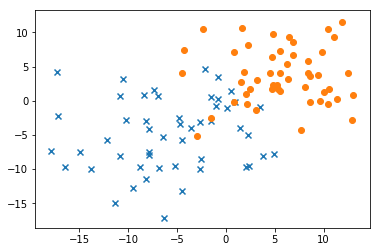

In [2]:
# Generate binary class dataset
center = [5,5]
n_samples = 100
X1 = np.random.normal(0,5,(int(n_samples/2),2)) - center
X2 = np.random.normal(0,5,(int(n_samples/2),2)) + center
X = np.concatenate((X1,X2),0)
Y = np.ones((n_samples,))
Y[:int(n_samples/2)] = -1

plt.figure()
plt.scatter(X1[:,0],X1[:,1],marker='x')
plt.scatter(X2[:,0],X2[:,1],marker='o')
plt.show()

1.Train a support vector machine on the data with $C=1$ and draw a line that separates o and x. Mark each of the support vectors separately and clearly (e.g. by putting a circle around the point).

Note: You can use LinearSVC or SVC from scikit-learn. If you use SVC, be sure to use the linear kernel as follows: SVC(kernel='linear'...).

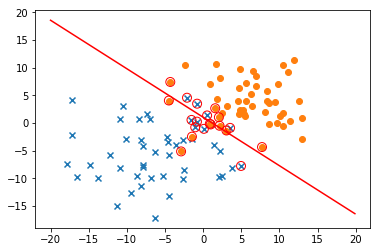

In [3]:
from sklearn.svm import SVC

clf = SVC(C=1.0, max_iter=5000, kernel='linear')
clf.fit(X,Y)

y_coef, x_coef = clf.coef_[0]
intercept = clf.intercept_

m = -x_coef/y_coef
intercept = intercept/y_coef

x = [x/10 for x in range(-200,200)]
y = [m*i - intercept for i in x]

support_vectors = clf.support_vectors_

plt.figure()
plt.scatter(X1[:,0],X1[:,1],marker='x')
plt.scatter(X2[:,0],X2[:,1],marker='o')
plt.scatter(support_vectors[:,0],support_vectors[:,1], s=80, facecolors='none', edgecolors='r')
plt.plot(x,y, color='r')
plt.show()

2.Draw a line that separates the data for 8 different $C$ ($10^{-3}$~$10^5$). Also, plot the number of support vectors vs. $C$ (plot x-axis on a log scale). How does the number of support vectors change as $C$ increases and why does it change like that? 

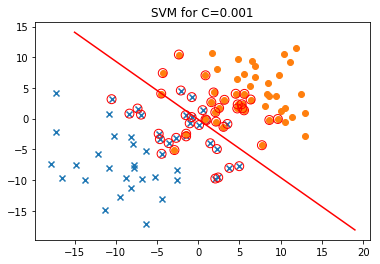

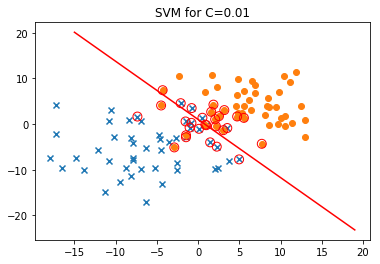

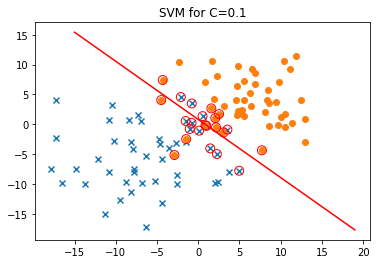

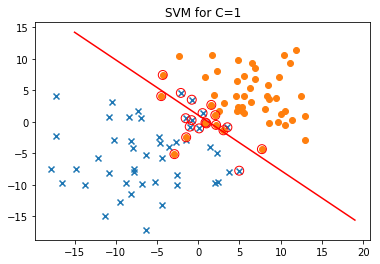

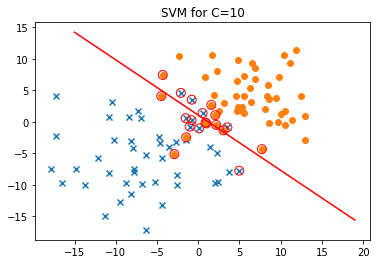

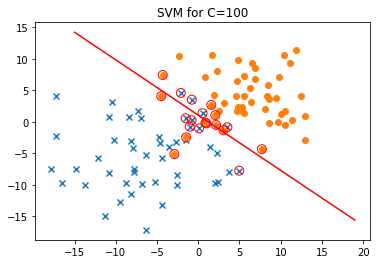

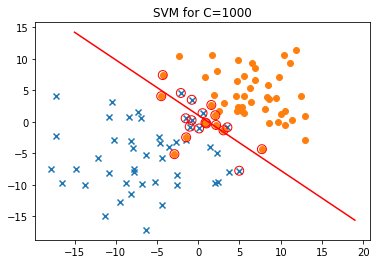

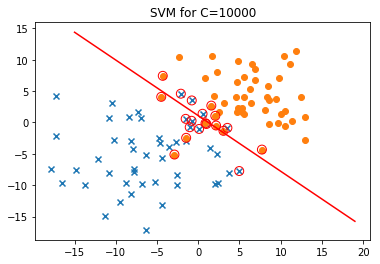

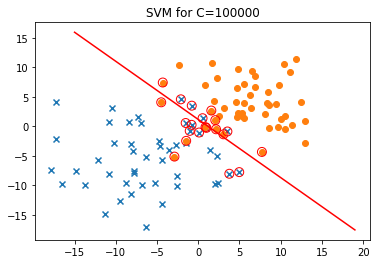

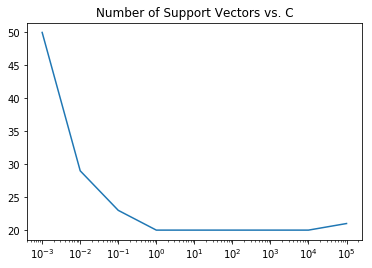

In [4]:
C = [10**i for i in range(-3,6)]
num_support_vectors = []

for c in C:
    clf = SVC(C=c, max_iter=10**9, kernel='linear')
    clf.fit(X,Y)

    y_coef, x_coef = clf.coef_[0]
    intercept = clf.intercept_

    m = -x_coef/y_coef
    intercept = intercept/y_coef

    x = [x for x in range(-15,20)]
    y = [m*i - intercept for i in x]

    support_vectors = clf.support_vectors_
    
    num_support_vectors.append(len(support_vectors))

    plt.figure()
    plt.scatter(X1[:,0],X1[:,1],marker='x')
    plt.scatter(X2[:,0],X2[:,1],marker='o')
    plt.scatter(support_vectors[:,0],support_vectors[:,1], s=80, facecolors='none', edgecolors='r')
    plt.plot(x,y, color='r')
    plt.title('SVM for C=' + str(c))
    plt.show()
    
plt.figure()
plt.plot(C, num_support_vectors)
plt.xscale('log')
plt.title('Number of Support Vectors vs. C')
plt.show()

## Binary Classification

#### Load the YALE database.

X_train: Train data (32256 x 1520) - 40 examples for 38 subjects.

Y_train: Train label (38 subjects (0~37))

X_test: Test data (32256 x 894) - Each subject has different number of test examples.

Y_test: Test label

Train Data: 32256 x 1520
Test Data: 32256 x 894


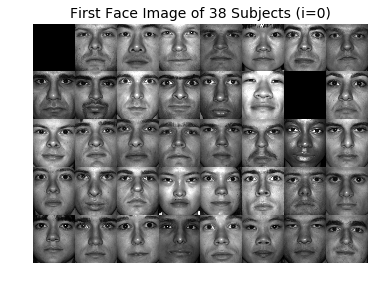

In [5]:
# Load the YALE database
YALE = io.loadmat('YALEBXF.mat') 
X = YALE['X']/255.
Y = YALE['Y']
nr, nc = 192, 168 # height = 192, width = 168
dim = nr * nc     # dimension = 32256
nex = X.shape[1]  # Total number of examples = 2414

nFc = 38          # Total number of faces
nImg = np.zeros(nFc+2) # Numper of examples for each person
for i in range(nFc+2):
    nImg[i] = (Y==i).sum()

ntr = 40
X_train = np.zeros((dim,nFc*ntr))
Y_train = np.zeros(nFc*ntr)
X_test = np.zeros((dim,nex-nFc*ntr))
Y_test = np.zeros(nex-nFc*ntr)

nImg_eff = nImg[np.where(nImg>0)]
nImg_test = nImg_eff - ntr
for i in range(nFc):
    X_train[:,i*ntr:(i+1)*ntr] = X[:,int(np.sum(nImg_eff[:i])):int(np.sum(nImg_eff[:i]))+40]
    Y_train[i*ntr:(i+1)*ntr] = i
    X_test[:,int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = X[:,int(np.sum(nImg_eff[:i]))+40:int(np.sum(nImg_eff[:i+1]))]
    Y_test[int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = i
    
print('Train Data: %d x %d' %(X_train.shape[0],X_train.shape[1]))
print('Test Data: %d x %d' %(X_test.shape[0],X_test.shape[1]))


def unpackcw(x,nr):
    return x.reshape(-1,nr).T

# Face board of 38 faces
faceIdx = 0 # index of face to display for each subject
Bh, Bw = 5, 8
FB = np.zeros((Bh*nr, Bw*nc))
for i in range(nFc+2):
    if nImg[i]>0:
        loc = np.where(Y==i)[1]
        x = X[:,loc[faceIdx]]
        A = unpackcw(x,nr)
        row, col = divmod(i,Bw)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (6,6))
plt.imshow(FB, cmap='gray')
plt.axis('off')
plt.title("First Face Image of 38 Subjects (i=%i)" %faceIdx, fontsize=14)
plt.show()

3.Center both the train data and test data using the mean of the train data. Then, project the train data and test data onto the first 128 principal components of the centered train data.

Note: Output should be 128 x N for both the train data and the test data (i.e. lying in the reduced dimension).

In [6]:
mean = np.mean(X_train, axis=1, keepdims=True)

X_train_pca = X_train - mean
X_test_pca = X_test - mean

from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca.fit(X_train_pca.T)
X_train_pca = pca.transform(X_train_pca.T).T
X_test_pca = pca.transform(X_test_pca.T).T

print(X_train_pca.shape)
print(X_test_pca.shape)

(128, 1520)
(128, 894)


4.Train the binary classifier using support vector machine to classify subject 0 and subject 1. Use the projected data. Plot accuracy vs. $C$ for $C=10^{-5}$~$10^{5}$ (plot x-axis on a log scale). 

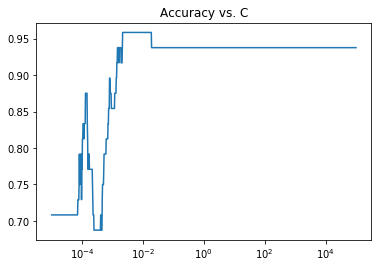

In [7]:
C = [10**i for i in np.linspace(-5,5,1000)]
accuracies = []

subject_1 = 0
subject_2 = 1

for c in C:
    X_1 = X_train_pca[:,subject_1*40:(subject_1+1)*40]
    X_2 = X_train_pca[:,subject_2*40:(subject_2+1)*40]
    X_pca = np.concatenate((X_1,X_2),1).T
    Y_pca = np.ones((80,))
    Y_pca[:int(80/2)] = -1

    clf = SVC(C=c, max_iter=10**9, kernel='linear')
    clf.fit(X_pca,Y_pca)
    
    mask_1 = Y_test == subject_1
    mask_2 = Y_test == subject_2

    X_1 = X_test_pca[:,mask_1]
    X_2 = X_test_pca[:,mask_2]
    X_pca_test = np.concatenate((X_1,X_2),1).T
    
    Y_test_1 = Y_test[mask_1]
    Y_test_2 = Y_test[mask_2]

    Y_test_1[:] = -1
    Y_test_2[:] = 1
    
    Y_pca_test = np.concatenate((Y_test_1,Y_test_2)).T

    accuracies.append(clf.score(X_pca_test, Y_pca_test))
    
plt.figure()
plt.plot(C, accuracies)
plt.xscale('log')
plt.title('Accuracy vs. C')
plt.show()

5.Repeat 4 with subject 2 and subject 25.

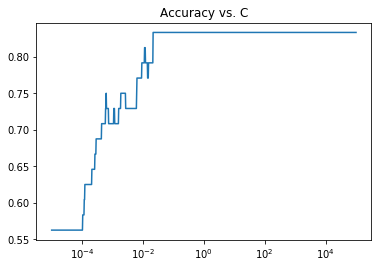

In [8]:
C = [10**i for i in np.linspace(-5,5,1000)]
accuracies = []

subject_1 = 2
subject_2 = 25

for c in C:
    X_1 = X_train_pca[:,subject_1*40:(subject_1+1)*40]
    X_2 = X_train_pca[:,subject_2*40:(subject_2+1)*40]
    X_pca = np.concatenate((X_1,X_2),1).T
    Y_pca = np.ones((80,))
    Y_pca[:int(80/2)] = -1

    clf = SVC(C=c, max_iter=10**9, kernel='linear')
    clf.fit(X_pca,Y_pca)
    
    mask_1 = Y_test == subject_1
    mask_2 = Y_test == subject_2

    X_1 = X_test_pca[:,mask_1]
    X_2 = X_test_pca[:,mask_2]
    X_pca_test = np.concatenate((X_1,X_2),1).T
    
    Y_test_1 = Y_test[mask_1]
    Y_test_2 = Y_test[mask_2]
    Y_test_1[:] = -1
    Y_test_2[:] = 1
        
    Y_pca_test = np.concatenate((Y_test_1,Y_test_2)).T

    accuracies.append(clf.score(X_pca_test, Y_pca_test))
    
plt.figure()
plt.plot(C, accuracies)
plt.xscale('log')
plt.title('Accuracy vs. C')
plt.show()

## Multi-class Classification

Now, we will use the support vector machine to carry out multi-class classification.

6.Standardize (centering and transforming to have unit variance for all features) the train data and test data. Use the data projected to the top 128 principal components from the previous question.

Note: Use sklearn.preprocessing.StandardScaler for the standardization step.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_pca.T)
X_train_scaled = scaler.transform(X_train_pca.T)
X_test_scaled = scaler.transform(X_test_pca.T)

7.Train one-vs-rest classifier on the train data to classify subjects 0~37. Use a support vector machine with $C=0.01$. Plot a bar graph of each subject's accuracy. What is the overall accuracy of the classifier?

Note: Use sklearn.multiclass.OneVsRestClassifier which allows you to convert any appropriate estimation function into a multi-class classifier.

Accuracy on test: 0.5134228187919463


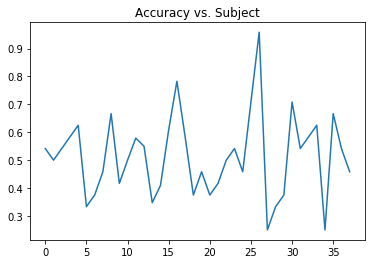

In [10]:
from sklearn.multiclass import OneVsRestClassifier

clf = SVC(C=0.01, max_iter=10**9, kernel='linear')
clf = OneVsRestClassifier(clf)
clf.fit(X_train_scaled, Y_train)

print('Accuracy on test: ' + str(clf.score(X_test_scaled, Y_test)))

accuracies = []

for subject in range(0,38):
    
    mask = Y_test == subject
    accuracies.append(clf.score(X_test_scaled[mask], Y_test[mask]))
    
plt.figure()
plt.plot(np.linspace(0,37,38), accuracies)
plt.title('Accuracy vs. Subject')
plt.show()